In [ ]:
! pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=a313900dec3daf9c6bd5aa95e06bf95f2f5a74cfaca11656e15cc6e2e1a97c89
  Stored in directory: /root/.cache/pip/wheels/00/3e/fa/5705bf59c2053c17c4799c3ab66a2e356c32f40a3044fe2134
Successfully built pyDOE


In [ ]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cpu


In [ ]:
steps=10000
lr=0.1
layers = np.array([2,40,40,40,40,40,40,40,40,1]) #8 hidden layers
#Nu: Number of training points 
#Nf: Number of collocation points (Evaluate PDE)
N_u = 100 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

x_min=-5
x_max=5
t_min=0
t_max=1
total_points_x=200
total_points_t=100


# **plot**

In [ ]:
def plot3D(x,t,y):
  x_plot=x.squeeze(1) #.squeeze(1) 张量降维
  t_plot=t.squeeze(1)
  X,T=torch.meshgrid(x_plot,t_plot) #torch.meshgrid  生成网格
  F_xt=y
  fig,ax=plt.subplots(1,1) #此处是一个1*1的图
  cp = ax.contourf(T,X,F_xt,20,cmap='rainbow') #contourf 用于绘制轮廓。但是轮廓线绘制填充轮廓，而轮廓线绘制轮廓线。
  fig.colorbar(cp) #Add a colorbar to a plot
  ax.set_title('F(x,t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(),X.numpy(),F_xt.numpy(),cmap='rainbow')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [ ]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [ ]:
def solutionplot(u_pred,X_u_train,u_train):
  #https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 0.5, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,usol.T[25,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.25s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-5.1,5.1])
    ax.set_ylim([-1.1,2.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-5.1,5.1])
    ax.set_ylim([-1.1,2.1])
    ax.set_title('$t = 0.50s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-5.1,5.1])
    ax.set_ylim([-1.1,2.1])    
    ax.set_title('$t = 0.75s$', fontsize = 10)
    
    plt.savefig('KdV.png',dpi = 500)

# **DNN**

In [ ]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a

In [ ]:
lambda1=2.0
lambda2=0.2

print("Te real 𝜆 = [", 6.0,1.0,"]. Our initial guess will be 𝜆 _PINN= [",lambda1,lambda2,"]")

Te real 𝜆 = [ 6.0 1.0 ]. Our initial guess will be 𝜆 _PINN= [ 2.0 0.2 ]


# Problem Setup

**Burgers' Equation**

$$\frac{\partial u}{\partial t}+ \lambda_1u\frac{\partial u}{\partial x}=\lambda_2\frac{\partial^2 u}{\partial x^2} $$

$$x\in[-5,5]$$
$$t\in[0,1]$$

# Inverse Problems

**Forward Problem**: Model$→$Data (Predict)

**Inverse Problem**: Data→Model (i.e., actually, we get the Model's parameters)

###Example


A Neural Network is an example of an inverse problem:

1.   We have an unknown model that follows:

$$N(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

2.   We use our "training" data to get $W_i$ and $b_i$; for $i=1,2,..\#layers$.


Specifically:

Data → Model i.e., estimate our model parameters (i,e., $W_i$ and $b_i$)




# PINNs for Inverse Problems or "Data-driven Discovery of Nonlinear Partial Differential Equations"

**Inverse Problem**: Data$→$Model's parameters so:

Data →PINN→ Model Parameters (i.e., our PDE parameters)

For parameterized and nonlinear partial differential equations of the general form (Raissi et al., 2017):

$$u_t+\mathscr{N}[u;\lambda]=0$$

where, $u(x,t)$ is the hidden solution and $\mathscr{N}[;\lambda]$ is a nonlinear operator parameterized by $\lambda$.

In short: We will use a PINN to get $\lambda$.


## Analysis:

Let:

$u_t=\frac{\partial u}{\partial t}$

$u_x=\frac{\partial u}{\partial x}$

$u_{xx}=\frac{\partial^2 u}{\partial x^2}$

$\mathscr{N}[u;\lambda]=\lambda_1u u_x+\lambda_2 u_{xxx}$

Our PDE is described as:

$$u_t+\lambda_1uu_x+\lambda_2u_{xxx}=0$$


Or,

$$u_t+\mathscr{N}[u;\lambda]=0$$

So we can use a PINN to obtain $\lambda$

In our case (from the reference solution) $\lambda=[\lambda_1,\lambda_2]=\left[5,0.5\right]$

## Neural Network

A Neural Network is a function 

$$N(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

**Note:**We usually train our N by iteratively minimizing a loss function in the training dataset(known data) to get $W_i$ and $b_i$.
 
## PINNs=Neural Network + PDE 

We can use a neural network to approximate any function (Universal APproximation Theorem): 
$$N(x,t)\approx u(x,t)$$ 

Since N(x,t) is a function, we can obtain its derivatives: $\frac{\partial N}{\partial t},\frac{\partial^2 N}{\partial x^2}, etc.$.(Automatic Diferentiation) 

Assume:$$N(t,x)\approx u(t,x)$$ 

Then:

$$N_t+\lambda_1NN_x+\lambda_2 N_{xxx}\approx u_t+\lambda_1 uu_x+\lambda_2 u_{xxx}=0$$

And:

$$N_t+\lambda_1NN_x+\lambda_2 N_{xxx}\approx 0$$


We define this function as $f$:

$$f(t,x)=N_t+\lambda_1NN_x+\lambda_2N_{xxx}$$

Remember our operator:

$$f(t,x)=N_t+\mathscr{N}[N,\lambda]$$

So:

$$f(t,x)\approx 0$$

### PINNs' Loss function

We evaluate $f$ in a certain number of points ($N_u$) inside our domain $(x,t)$. Then we iteratively minimize a loss function related to $f$:

$$MSE_f=\frac{1}{N_u}\sum^{N_u}_{i=1}|f(t_u^i,x_u^i)|^2$$

Usually, the training data set is a set of points from which we know the answer. In our case, points inside our domain (i.e., interior points). **Remember that this is an inverse problem, so we know the data.**

Since we know the outcome, we select $N$ and compute the $MSE_u$** (compare it to the reference solution).

$$MSE_{u}=\frac{1}{N_u}\sum^{N_u}_{i=1}|u(t_{u}^i,x_u^i)-N(t_{u}^i,x_u^i)|^2$$

Please note that $\{t_u^i,x_u^i\}_{i=1}^N$ are the same in $MSE_f$ and $MSE_u$

#### Total Loss:

$$MSE=MSE_{u}+MSE_f$$

NOTE: We minimize $MSE$ to obtain the $N$'s parameters (i.e, $W_i$ and $b_i$) and the ODE parameters (i.e., $\lambda$)→ We will ask our neural network to find our $\lambda$.

# **FCN**

In [ ]:
class FCN():
    def __init__(self, layers):
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialize iterator'
        self.iter = 0
        'Initialize our new parameters i.e. 𝜆 (Inverse problem)' 
        self.lambda1 = torch.tensor([lambda1], requires_grad=True).float().to(device)  
        self.lambda2 = torch.tensor([lambda2], requires_grad=True).float().to(device)  
        'Register lambda to optimize'
        self.lambda1 = nn.Parameter(self.lambda1)
        self.lambda2 = nn.Parameter(self.lambda2)
        'Call our DNN'
        self.dnn = DNN(layers).to(device)
        'Register our new parameter'
        self.dnn.register_parameter('lambda1', self.lambda1)  
        self.dnn.register_parameter('lambda2', self.lambda2)                                                           
            
    def loss_data(self,x,y):
                
        loss_u = self.loss_function(self.dnn(x), y)
      
        return loss_u
    
    def loss_PDE(self, x_PDE):

      lambda1=self.lambda1
      lambda2=self.lambda2
                        
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      u=self.dnn(g)

      u_x_t = autograd.grad(u,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
      u_xx_tt = autograd.grad(u_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]#second derivative
      u_xxx_ttt = autograd.grad(u_xx_tt,g,torch.ones(g.shape).to(device), create_graph=True)[0]#second derivative

      u_t=u_x_t[:,[1]] # we select the 2nd element for t (the first one is x) (Remember the input X=[x,t]) 
      u_x=u_x_t[:,[0]] # we select the 2nd element for t (the first one is x) (Remember the input X=[x,t]) 
      u_xxx=u_xxx_ttt[:,[0]]

      f = u_t + (lambda1)*(self.dnn(g))*(u_x) + (lambda2)*u_xxx 
      loss_f = self.loss_function(f,f_hat)

      return loss_f

    def loss(self,x,y):

        loss_u = self.loss_data(x,y)
        loss_f = self.loss_PDE(x)
        
        loss_val = loss_u + loss_f
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.loss(X_train_Nu, U_train_Nu)
        
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 100 == 0:

            error_vec, u_pred = PINN.test()
        
            print(
                'Relative Error: %.5f,𝜆_real=[6.0,1.0] 𝜆_PINN = [%.5f,  %.5f]' %
                (
                    error_vec.cpu().detach().numpy(),
                    self.lambda1.item(),
                    self.lambda2.item()
                )
            )
            if error_vec > 0.01:
              solutionplot(u_pred,X_train_Nu.cpu().detach().numpy(),U_train_Nu)
            

        return loss               
    
    'test neural network'
    def test(self):
                
        u_pred = self.dnn(X_true)
        
        error_vec = torch.linalg.norm((u-u_pred),2)/torch.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
        
        u_pred = u_pred.cpu().detach().numpy()
        
        u_pred = np.reshape(u_pred,(x.shape[0],t.shape[0]),order='F')
                
        return error_vec, u_pred

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


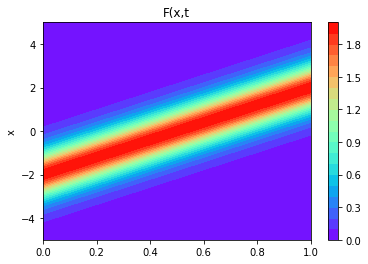

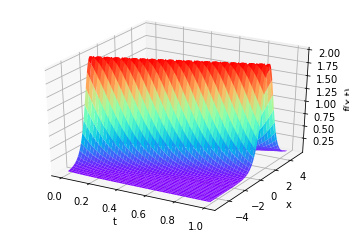

In [ ]:
def sech(x):
  y = 2/(np.exp(x)+np.exp(-x))
  return y
  
def u_real(x,t):
  y = x-4*t+2
  return 2*sech(y)**2

x=torch.linspace(x_min,x_max,total_points_x).view(-1,1)
t=torch.linspace(t_min,t_max,total_points_t).view(-1,1)
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))
# Evaluate real function
usol=u_real(X,T)
plot3D(x,t,usol)

In [ ]:
print(x.shape,t.shape,usol.shape)
print(X.shape,T.shape)

torch.Size([200, 1]) torch.Size([100, 1]) torch.Size([200, 100])
torch.Size([200, 100]) torch.Size([200, 100])


In [ ]:
x = x.numpy()
t = t.numpy()
usol = usol.numpy()
X = X.numpy().T
T = T.numpy().T

print(x.shape,t.shape,usol.shape)
print(X.shape,T.shape)

(200, 1) (100, 1) (200, 100)
(100, 200) (100, 200)


In [ ]:
X_true = np.hstack((X.flatten()[:,None],T.flatten()[:,None]))

lb = X_true[0]
ub = X_true[-1]
u_true = usol.flatten('F')[:,None]

In [ ]:
print(lb,ub)

[-5.  0.] [5. 1.]


In [ ]:
print(u_true)

[[0.01973207]
 [0.02180688]
 [0.0240985 ]
 ...
 [0.0240985 ]
 [0.02180688]
 [0.01973207]]


In [ ]:
total_points=len(x)*len(t)
print(total_points)

20000


In [ ]:
#choose random N_u points for training
id_f = np.random.choice(total_points, N_f, replace=False) 

X_train_Nu = X_true[id_f] #choose indices from  set 'idx' (x,t)
U_train_Nu = u_true[id_f]      #choose corresponding u


In [ ]:
print(X_train_Nu.shape[0])
print(id_f)

10000
[18172 16075 15388 ...  9852 13932  5620]


In [ ]:
'Convert to tensor and send to GPU'
X_train_Nu = torch.from_numpy(X_train_Nu).float().to(device)
U_train_Nu = torch.from_numpy(U_train_Nu).float().to(device)
X_true = torch.from_numpy(X_true).float().to(device)
u = torch.from_numpy(u_true).float().to(device)
f_hat = torch.zeros(X_train_Nu.shape[0],1).to(device)

print(X_train_Nu.shape,U_train_Nu.shape,X_true.shape,u.shape,f_hat.shape)

torch.Size([10000, 2]) torch.Size([10000, 1]) torch.Size([20000, 2]) torch.Size([20000, 1]) torch.Size([10000, 1])


In [ ]:
PINN = FCN(layers)
       
PINN

'Neural Network Summary'
print(PINN)

Relative Error: 0.43569,𝜆_real=[6.0,1.0] 𝜆_PINN = [2.17580,  0.05462]
Relative Error: 0.04925,𝜆_real=[6.0,1.0] 𝜆_PINN = [5.93029,  0.10305]
Relative Error: 0.01346,𝜆_real=[6.0,1.0] 𝜆_PINN = [5.86490,  0.10568]
Relative Error: 0.00572,𝜆_real=[6.0,1.0] 𝜆_PINN = [5.97633,  0.11022]
Relative Error: 0.00395,𝜆_real=[6.0,1.0] 𝜆_PINN = [5.98323,  0.11021]
Relative Error: 0.00188,𝜆_real=[6.0,1.0] 𝜆_PINN = [5.98777,  0.11044]
Relative Error: 0.00105,𝜆_real=[6.0,1.0] 𝜆_PINN = [5.99647,  0.11091]
Relative Error: 0.00072,𝜆_real=[6.0,1.0] 𝜆_PINN = [5.99662,  0.11089]
Relative Error: 0.00061,𝜆_real=[6.0,1.0] 𝜆_PINN = [5.99747,  0.11103]
Relative Error: 0.00043,𝜆_real=[6.0,1.0] 𝜆_PINN = [5.99979,  0.11111]
Relative Error: 0.00027,𝜆_real=[6.0,1.0] 𝜆_PINN = [6.00086,  0.11120]
Relative Error: 0.00031,𝜆_real=[6.0,1.0] 𝜆_PINN = [6.00132,  0.11121]
Relative Error: 0.00031,𝜆_real=[6.0,1.0] 𝜆_PINN = [6.00027,  0.11114]
Training time: 727.49
Test Error: 0.00030


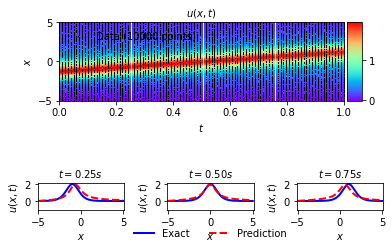

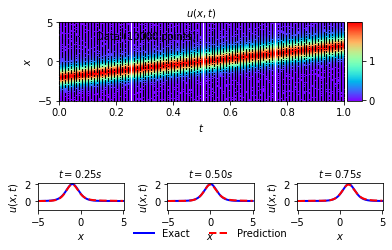

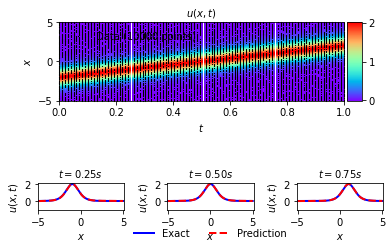

In [ ]:
params = list(PINN.dnn.parameters())

'''Optimization'''

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(params, lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-11, 
                              tolerance_change = 1e-11, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

start_time = time.time()

optimizer.step(PINN.closure)
    
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))


''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()

print('Test Error: %.5f'  % (error_vec))

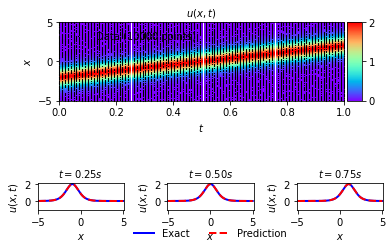

In [ ]:
solutionplot(u_pred,X_train_Nu.cpu().detach().numpy(),U_train_Nu)

In [ ]:
x1=X_true[:,0]
t1=X_true[:,1]

In [ ]:
arr_x1=x1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_y1=u_pred
arr_y_test=usol

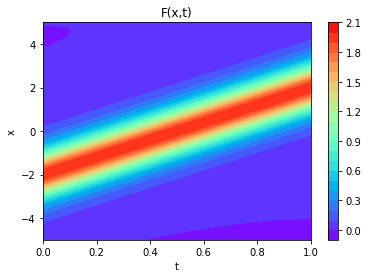

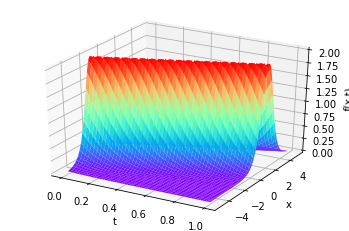

In [ ]:
plot3D_Matrix(arr_x1,arr_T1,torch.from_numpy(arr_y1))

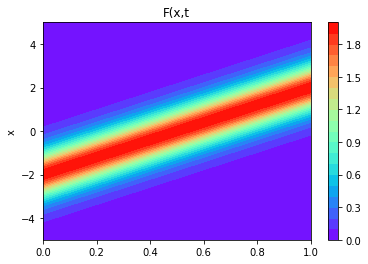

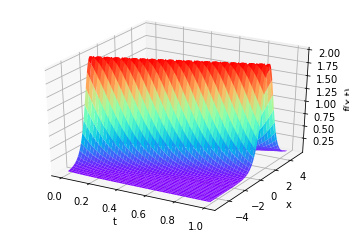

In [ ]:
plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol)) 

[1] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations. arXiv preprint arXiv:1711.10561. http://arxiv.org/pdf/1711.10561v1

[2] Lu, L., Meng, X., Mao, Z., & Karniadakis, G. E. (1907). DeepXDE: A deep learning library for solving differential equations,(2019). URL http://arxiv. org/abs/1907.04502. https://arxiv.org/abs/1907.04502

[3] Rackauckas Chris, Introduction to Scientific Machine Learning through Physics-Informed Neural Networks. https://book.sciml.ai/notes/03/

[4] Repository: Physics-Informed-Neural-Networks (PINNs).https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation

[5] Repository:Juan Diego Toscano(2022)
Learning-PIML-in-Python.
https://github.com/jdtoscano94/Learning-Python-Physics-Informed-Machine-Learning-PINNs-DeepONets